In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest


# Quiet setting warnings
pd.options.mode.chained_assignment = None

# non-linear regression

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


1. Data exploration
2. Data imputation
3. Label encoder
4. Correlation plot
5. Potentially drop features, maybe regularize data
6. Look at inflation factor
7. Age is the only non-linear
8. Racial imbalance problem (introduce weight during optimization)

# Study Summary
The National Institutes of Health funded a study to analyze what factors may predict the survival time after diagnosis of a terminal type of liver cancer. 2,500 patients were enrolled in ten different U.S. hospital and each patient underwent a biopsy that provided a measurement of twenty quantitative cell measurements. The overall goal of this study is to identify which cell measurements (if any) may be predictors of the survival time in addition to basic patient demographic information.

In [2]:
# Import data
WORK_DIR = os.getcwd()
filename = 'CancerSurvivalData.xlsx'
data = pd.read_excel(f'{WORK_DIR}/{filename}')
data.head(5)

,Age (years),Sex,Racial group,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
0,68.475758,Female,Hispanic or Latino,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,...,66.071899,-25.324697,-20.617584,-12.444847,20.939882,6.009270,37.900230,17.272812,0.024656,11.508051
1,73.986450,Female,White,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,...,69.831818,-27.426292,-27.363832,-4.045206,22.637911,2.613145,41.289307,18.726410,2.884620,9.522676
2,70.285954,Male,White,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,...,61.370747,-25.570925,-26.268887,-4.757288,22.608706,0.150276,41.231022,17.960768,2.642166,8.472567
3,46.744625,Female,White,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,...,65.829353,-27.222082,-27.243317,-9.449100,22.249207,-5.450154,40.513496,19.318758,1.044667,5.196368
4,71.733703,Male,White,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,...,68.680405,-28.357386,-27.913317,-9.928357,32.855518,-1.246710,42.646397,17.513947,0.881487,11.254032


# EDA

## Numeric Feature Description

In [3]:
# Numeric feature description
data.describe()

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
count,2500.000000,2475.000000,2500.000000,2500.000000,2500.000000,2500.000000,2475.000000,2475.000000,2475.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,59.773374,17.588542,-19.896005,-30.763323,-16.371843,7.727473,-24.633922,21.547991,18.201625,26.162695,...,66.132120,-25.193814,-26.059773,-6.702052,21.512696,-2.038330,39.182691,17.026247,1.934536,10.895709
std,14.348879,163.808559,216.157161,74.141591,140.671828,34.534136,224.934601,12.908406,150.429658,100.691082,...,5.821518,2.612992,1.546289,3.993389,2.684297,4.893757,5.235889,2.743260,1.364199,3.206183
min,35.001743,-878.126172,-1236.026054,-435.425713,-793.308449,-185.306389,-1260.801076,-50.924635,-771.666265,-520.623360,...,34.532265,-39.552357,-34.658710,-29.201059,6.505697,-29.405554,9.441338,1.953396,-5.709943,0.072005
25%,47.633235,-69.345184,-145.136016,-70.669285,-91.424987,-11.691762,-150.045253,14.226298,-66.262320,-27.983604,...,63.054063,-26.630280,-26.898159,-8.867526,19.969954,-4.715758,35.993000,15.407598,1.221699,8.642281
50%,59.627499,21.256436,-24.282828,-32.277297,-14.337473,6.953394,-24.547570,21.439340,17.049534,26.587640,...,66.075119,-25.187329,-26.051076,-6.755655,21.470248,-2.013940,39.001196,16.961409,1.958993,10.866867
75%,72.121240,112.987928,98.278272,8.721793,60.749048,26.856821,101.179330,28.737636,100.445638,83.404390,...,69.336325,-23.713014,-25.176544,-4.494916,22.985312,0.708450,42.050601,18.519073,2.723695,13.051807
max,84.960572,918.594159,1191.275835,371.666717,765.548343,198.980592,1211.526446,92.571795,849.890335,587.655878,...,98.055527,-10.783654,-17.846529,15.955807,36.261654,25.352072,68.617393,32.375202,9.615926,20.721592


## Missing Values

In [4]:
# Determine number of missing values in each column
data.isnull().sum()

Age (years)                0
Sex                        0
Racial group             237
Cell profile 0            25
Cell profile 1             0
Cell profile 2             0
Cell profile 3             0
Cell profile 4             0
Cell profile 5            25
Cell profile 6            25
Cell profile 7            25
Cell profile 8             0
Cell profile 9             0
Cell profile 10            0
Cell profile 11            0
Cell profile 12            0
Cell profile 13            0
Cell profile 14            0
Cell profile 15            0
Cell profile 16            0
Cell profile 17            0
Cell profile 18            0
Cell profile 19            0
Survival time (years)      0
dtype: int64

## Feature Visualization

In [5]:
def num_feature_dist_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=30)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()
        

def cat_feature_count_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''

    # Extract features to plot - only non-numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    nonnumeric_features = [feature for feature in X.columns if feature not in numeric_features]
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(nonnumeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(nonnumeric_features):
        
        # Set count df for plot
        labels = list(set(X[feature]))
        counts = [list(X[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                                'counts': counts})
        
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    plt.show()
    

In [6]:
# Split df into target/features
target = 'Survival time (years)'
X = data.loc[:, data.columns != target]
y = data.loc[:, target]

### Target Variable Distribution

Our target variable is survival time. The Shapiro test for normality returns a p-value of 0.26, which suggests that the distribution of our target variable is approximately normally distributed (at least we can't reject the hypothesis that it is normally distributed). Outliers seem minimal.

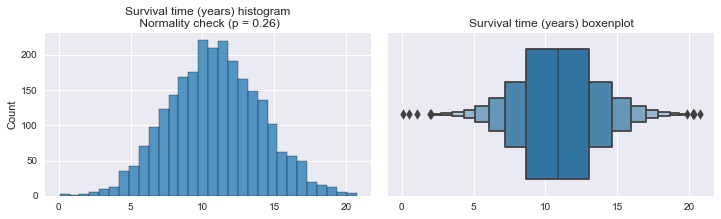

In [7]:
# Set figure space
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={"hspace": 0, "wspace": 0.05})

# Test for normality
test_stat, p = scipy.stats.shapiro(data[target])

# Plot, left side
sns.histplot(data=data, x=target, ax=ax[0], color='tab:blue', bins=30)
ax[0].set_title(f'{target} histogram\n Normality check (p = {round(p, 2)})', fontsize=12)
ax[0].set_xlabel('')

# Plot, right side
sns.boxenplot(data=data, x=target, ax=ax[1], color='tab:blue')
ax[1].set_title(f'{target} boxenplot', fontsize=12)
ax[1].set_xlabel('')
plt.show()

### Numeric Feature Distribution

The plots below show the distributions of numeric features in the data set. From the visualization we can see that most cell profile data are approximately normally distributed. Age is clearly not normally distributed, but roughly uniformly distributed. Fliers/potential outliers are noticeable from these visuals as well. None of the fliers/outliers seem like errors, so I'll opt to leave these values in the data set during modeling.


Numerical Feature Distributions:



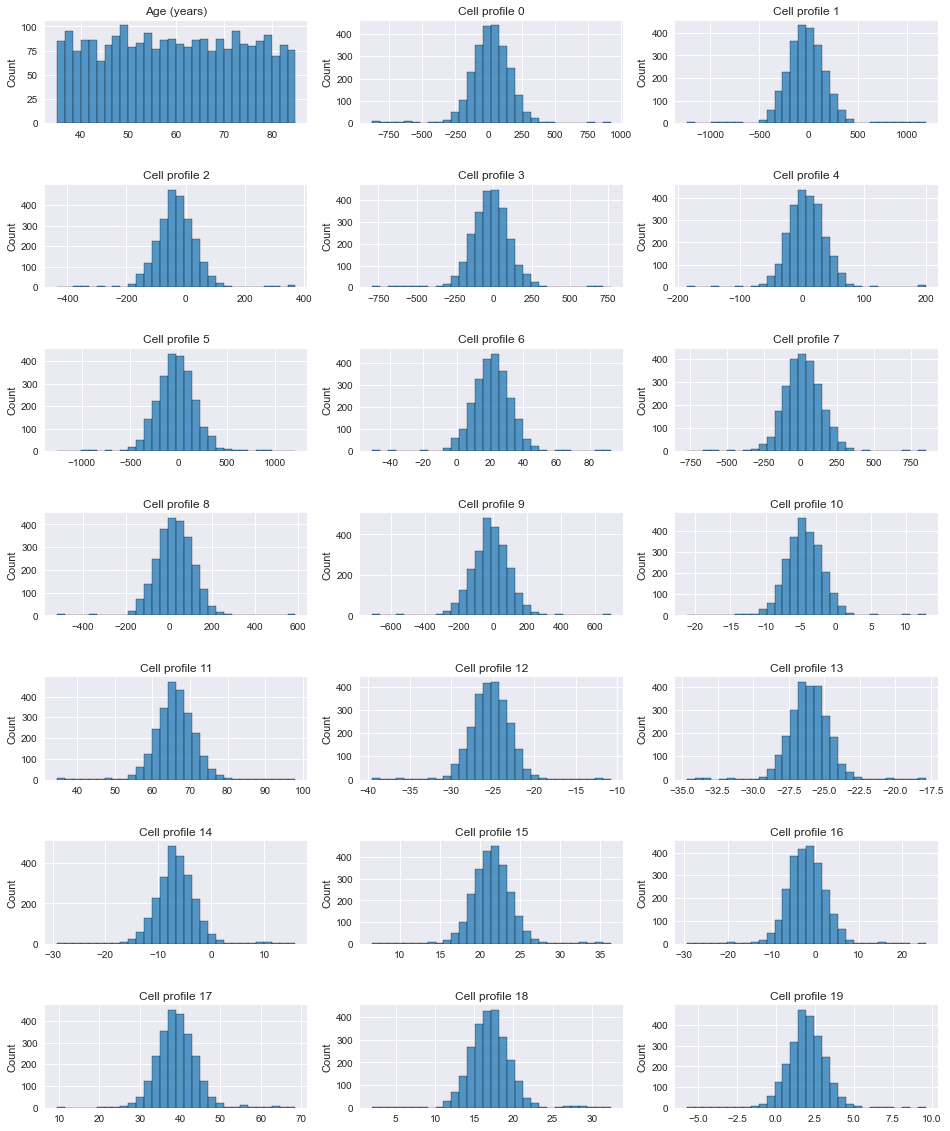

In [8]:
# Plot numeric feature distributions
print('\nNumerical Feature Distributions:\n')
num_feature_dist_plot(df=X, n_col=3, fig_width=16, fig_height=20, hspace=0.6, wspace=0.2)

### Categorical Feature Class Balance

**NOTE:** Heavy class imblance exists among racial groups


Categorical Feature Class Balance:



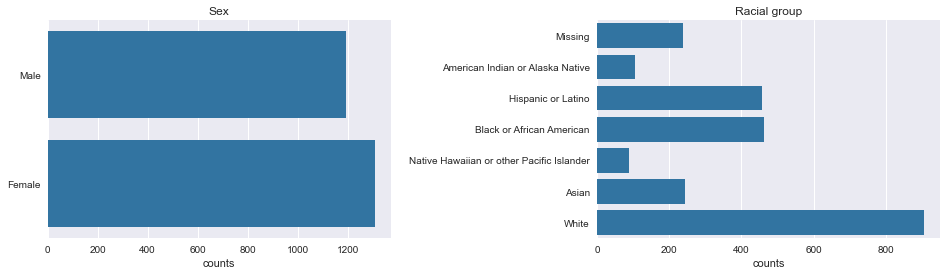

In [9]:
# Plot non-numeric feature distributions
print('\nCategorical Feature Class Balance:\n')
cat_feature_count_plot(df=X, n_col=2, fig_width=16, fig_height=4, hspace=0.6, wspace=0.6)

# Imputation

## Cell Profile Imputation Using Simple Imputation

Cell profile features are continuous. We can implement a simple imputation method to fill in these missing values. I'm going to opt for median imputation since outliers/fliers are apparent in the cell profile distribution plots. 

In [10]:
# Determine columns to impute values in
impute_cols = X.columns[X.isnull().any()].tolist()
impute_cols.remove('Racial group')

# Median imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for feature in impute_cols:
    X[feature] = imputer.fit_transform(X[feature].values.reshape(-1, 1))[:,0]


In [11]:
# Check that there are no missing values in imputed columns
X.isnull().sum()

Age (years)          0
Sex                  0
Racial group       237
Cell profile 0       0
Cell profile 1       0
Cell profile 2       0
Cell profile 3       0
Cell profile 4       0
Cell profile 5       0
Cell profile 6       0
Cell profile 7       0
Cell profile 8       0
Cell profile 9       0
Cell profile 10      0
Cell profile 11      0
Cell profile 12      0
Cell profile 13      0
Cell profile 14      0
Cell profile 15      0
Cell profile 16      0
Cell profile 17      0
Cell profile 18      0
Cell profile 19      0
dtype: int64

## Racial Group Imputation Using MissForest

Now that cell profile missing entries are handled, we can use all of our features (other than racial group) to impute missing racial group data. Note that the outcome will not be used to impute racial group since we will ultimately use racial group to predict the outcome. I'll use MissForest for this imputation step, which is an adaptation of Random Forest for imputation. One advantage of this approach is that no pre-processing is necessary (unlike kNN in which normalization is necessary). I do know, however, that sometimes Random Forest is sensitive to class imbalances - we might want to compare this approach to something like kNN imputation.

In [12]:
# Encode Variables
# NOTE: The racial group is not ordinal and should not be treated as so; however, the MissForest() imputer 
# requires that categorical variables be encoded and then specified in imputer.fit_transform "cat_vars" option
X['Sex'] = X['Sex'].map({'Male': 0, 'Female': 1})
X['Racial group'] = X['Racial group'].map({'White': int(0), 
                                           'American Indian or Alaska Native': int(1), 
                                           'Asian': int(2), 
                                           'Black or African American': int(3),
                                           'Hispanic or Latino': int(4),
                                           'Native Hawaiian or other Pacific Islander': int(5)})
# Check
X.head(5)

,Age (years),Sex,Racial group,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,...,Cell profile 10,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19
0,68.475758,1,4.0,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,...,-5.097365,66.071899,-25.324697,-20.617584,-12.444847,20.939882,6.009270,37.900230,17.272812,0.024656
1,73.986450,1,0.0,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,...,-3.143062,69.831818,-27.426292,-27.363832,-4.045206,22.637911,2.613145,41.289307,18.726410,2.884620
2,70.285954,0,0.0,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,...,-3.176673,61.370747,-25.570925,-26.268887,-4.757288,22.608706,0.150276,41.231022,17.960768,2.642166
3,46.744625,1,0.0,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,...,-3.590431,65.829353,-27.222082,-27.243317,-9.449100,22.249207,-5.450154,40.513496,19.318758,1.044667
4,71.733703,0,0.0,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,...,-2.360501,68.680405,-28.357386,-27.913317,-9.928357,32.855518,-1.246710,42.646397,17.513947,0.881487


In [13]:
# MissForest imputation
imputer = MissForest(n_estimators=500, random_state=7, class_weight="balanced_subsample")
X_MissForest = imputer.fit_transform(X, cat_vars=[1, 2])
X_MissForest_df = pd.DataFrame(X_MissForest, columns=X.columns)

Iteration: 0
Iteration: 1
Iteration: 2


In [14]:
# Check that there are no missing values in imputed column
X_MissForest_df.isnull().sum()

Age (years)        0
Sex                0
Racial group       0
Cell profile 0     0
Cell profile 1     0
Cell profile 2     0
Cell profile 3     0
Cell profile 4     0
Cell profile 5     0
Cell profile 6     0
Cell profile 7     0
Cell profile 8     0
Cell profile 9     0
Cell profile 10    0
Cell profile 11    0
Cell profile 12    0
Cell profile 13    0
Cell profile 14    0
Cell profile 15    0
Cell profile 16    0
Cell profile 17    0
Cell profile 18    0
Cell profile 19    0
dtype: int64

In [15]:
# Re-label encoded data - we will need to one-hot-encode these
X_MissForest_df['Racial group'] = X_MissForest_df['Racial group'].map(
    {0: 'White', 
     1: 'American Indian or Alaska Native', 
     2: 'Asian', 
     3: 'Black or African American',
     4: 'Hispanic or Latino',
     5: 'Native Hawaiian or other Pacific Islander'
    }
)

In [16]:
# Check which racial groups were imputed - expect imbalance here due to initial imbalance of sample
impute_assess_df = pd.DataFrame({
    'Original': list(X['Racial group']),
    'Imputed': list(X_MissForest_df['Racial group'])
})

impute_assess_df = impute_assess_df[impute_assess_df['Original'].isna()]
impute_assess_df.head(5)

,Original,Imputed
10,NaN,White
16,NaN,White
20,NaN,White
47,NaN,White
58,NaN,White


**NOTE:** Not all class types were imputed, which will imbalance the full data set even more. Nonetheless, this is a better approach (in my eyes) than using simple imputation and imputing all missing racial groups with the white class.

Text(0, 0.5, '')

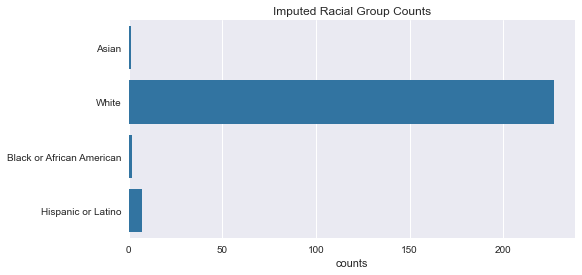

In [17]:
# Set count df for plot
feature = impute_assess_df['Imputed']
labels = list(set(feature))
counts = [list(feature).count(c) for c in labels]
plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                        'counts': counts})

# Bar plot of imputed values
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(data=plot_df, y="labels", x="counts", color="tab:blue")
ax.set_title('Imputed Racial Group Counts', fontsize=12)
ax.set_ylabel('')

# Further Exploration & Pre-Processing
## One-Hot-Encoding

In [18]:
# Set up final data set to store results
X_ohe = X_MissForest_df.copy()
X_ohe.drop(['Racial group'], axis=1, inplace=True) # We'll drop this and add in one-hot-encoded columns

# 1) Initialize OHE object
# 2) Fit and transform data
# 3) Add OHE columns into existing data frame
ohe = OneHotEncoder(handle_unknown='error')
ohe_transform = ohe.fit_transform(X_MissForest_df[['Racial group']])
X_ohe[ohe.categories_[0]] = ohe_transform.toarray()
X_ohe.head(5)

,Age (years),Sex,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,...,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,American Indian or Alaska Native,Asian,Black or African American,Hispanic or Latino,Native Hawaiian or other Pacific Islander,White
0,68.475758,1.0,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,263.818563,...,6.009270,37.900230,17.272812,0.024656,0.0,0.0,0.0,1.0,0.0,0.0
1,73.986450,1.0,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,159.291946,...,2.613145,41.289307,18.726410,2.884620,0.0,0.0,0.0,0.0,0.0,1.0
2,70.285954,0.0,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,83.489261,...,0.150276,41.231022,17.960768,2.642166,0.0,0.0,0.0,0.0,0.0,1.0
3,46.744625,1.0,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,-88.881909,...,-5.450154,40.513496,19.318758,1.044667,0.0,0.0,0.0,0.0,0.0,1.0
4,71.733703,0.0,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,40.492528,...,-1.246710,42.646397,17.513947,0.881487,0.0,0.0,0.0,0.0,0.0,1.0


## Multicollinearity Assessment
### Correlation Plot
From the correlation plot below, it is apparent that some cell profiles are somewhat correlated (pearson correlation coefficients ~0.60). We should consider regularization to limit the effects of multicollinearity. Below we check VIFs for each predictor.

Text(0.5, 1.0, 'Correlation Plot of Numeric Features')

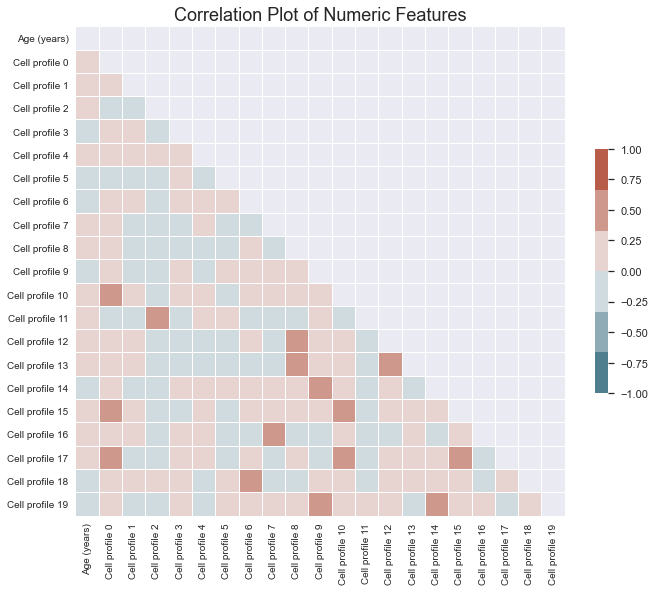

In [19]:
# Define binary features
binary_X = ['Sex', 'American Indian or Alaska Native', 'Asian', 'Black or African American','Hispanic or Latino', 
            'Native Hawaiian or other Pacific Islander', 'White']

# Extract numeric features
X_corr = X_ohe.copy()
X_corr.drop(binary_X, axis=1, inplace=True)

# Source for correlation plot: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = X_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
cmap = sns.diverging_palette(220, 20, s=60)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .5})
ax.set_title('Correlation Plot of Numeric Features', size=18)

### Variance Inflation Factors
The general rule of thumb is that a VIF > 5 might suggest collinearity. None of the VIFs below get near this. It could still be interesting seeing what removing the highest VIF features does to the model (start with Cell profile 17).

In [20]:
# Implementation source: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
X_vif = sm.add_constant(X_corr) # Add constant term
pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], index=X_vif.columns)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


const              1012.155830
Age (years)           1.007130
Cell profile 0        1.999041
Cell profile 1        1.008459
Cell profile 2        1.606415
Cell profile 3        1.003856
Cell profile 4        1.005901
Cell profile 5        1.006095
Cell profile 6        1.657453
Cell profile 7        1.562693
Cell profile 8        1.948667
Cell profile 9        1.996413
Cell profile 10       2.130158
Cell profile 11       1.604964
Cell profile 12       2.003454
Cell profile 13       1.925188
Cell profile 14       1.987266
Cell profile 15       2.057884
Cell profile 16       1.562739
Cell profile 17       2.136074
Cell profile 18       1.658960
Cell profile 19       1.983554
dtype: float64

Below shows updated VIFs when Cell profiles with the largest VIFs are removed. Again, there is no specific threshold for this. For the sake of fully eliminating multicollinearity, I used a **stringent** VIF threshold of 1.5. The largest VIF features were removed consecutively until no VIF was above 1.5. I'll use these features in the model.

In [21]:
X_vif2 = X_vif.copy()
drop_feats = ['Cell profile 17', 'Cell profile 12', 'Cell profile 9', 'Cell profile 10', 'Cell profile 14',
              'Cell profile 18', 'Cell profile 8', 'Cell profile 2', 'Cell profile 15', 'Cell profile 7']
X_vif2.drop(drop_feats, axis=1, inplace=True)
pd.Series([variance_inflation_factor(X_vif2.values, i) for i in range(X_vif2.shape[1])], index=X_vif2.columns)

const              436.008960
Age (years)          1.004081
Cell profile 0       1.004294
Cell profile 1       1.001776
Cell profile 3       1.002102
Cell profile 4       1.003544
Cell profile 5       1.004131
Cell profile 6       1.002245
Cell profile 11      1.003719
Cell profile 13      1.003838
Cell profile 16      1.005584
Cell profile 19      1.002278
dtype: float64

The correlation plot below shows the pairwise correlations between the remaining features. Multicollinearity issues should be eliminated now.

Text(0.5, 1.0, 'Correlation Plot of Numeric Features')

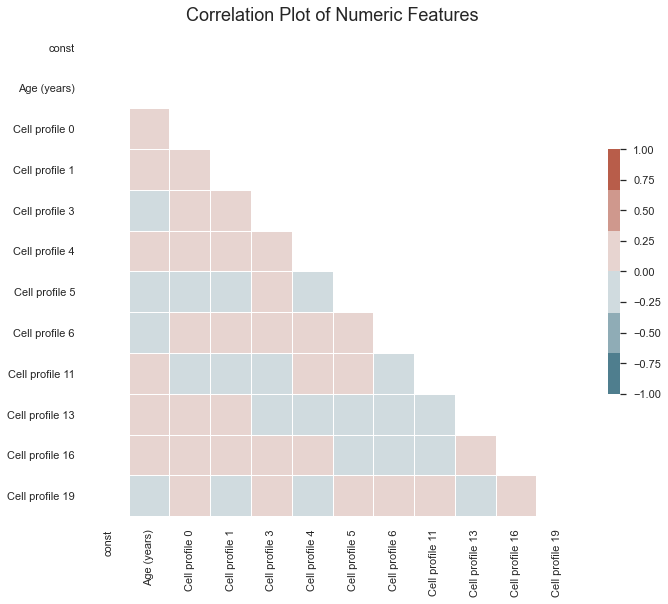

In [22]:
# Compute the correlation matrix
corr = X_vif2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
cmap = sns.diverging_palette(220, 20, s=60)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .5})
ax.set_title('Correlation Plot of Numeric Features', size=18)

## Feature Scaling (Standardization)
Prior to fitting the linear regression model we will standardize the data. This should be useful since our features are mostly normally distributed (although age is not) and linear regression assumes normality. Standardization is robust to outliers that may be present.

In [24]:
# Define binary features
binary_X = ['Sex', 'American Indian or Alaska Native', 'Asian', 'Black or African American','Hispanic or Latino', 
            'Native Hawaiian or other Pacific Islander', 'White']

# These are the cell profiles that demonstrated potential for multicollinearity
# NOTE: This is likely too stringent
drop_feats = ['Cell profile 17', 'Cell profile 12', 'Cell profile 9', 'Cell profile 10', 'Cell profile 14',
              'Cell profile 18', 'Cell profile 8', 'Cell profile 2', 'Cell profile 15', 'Cell profile 7']

# Extract features to standardize (non-binary features)
X_clean = X_ohe.copy()
X_clean.drop(binary_X, axis=1, inplace=True)
X_clean.drop(drop_feats, axis=1, inplace=True)
cols = X_clean.columns

# Standardize
scaler = StandardScaler()
X_clean = scaler.fit_transform(X_clean)
X_clean_df = pd.DataFrame(X_clean, columns=cols)
X_clean_df.head(5)

,Age (years),Cell profile 0,Cell profile 1,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 11,Cell profile 13,Cell profile 16,Cell profile 19
0,0.606607,-0.158217,-1.017288,-1.525878,-1.200674,-0.177085,0.109791,-0.010346,3.520220,1.644792,-1.400281
1,0.990734,0.465488,-0.638853,4.486851,-0.619981,-0.926268,0.639015,0.635648,-0.843517,0.950682,0.696580
2,0.732788,0.454761,-0.851144,-1.210008,-1.089198,-0.068787,0.360261,-0.818056,-0.135263,0.447314,0.518818
3,-0.908179,0.322712,0.013303,0.708043,-3.347861,-0.408577,0.854675,-0.052019,-0.765562,-0.697318,-0.652432
4,0.833704,0.715238,0.134538,0.523945,0.234297,-0.150843,0.197583,0.437823,-1.198944,0.161794,-0.772072


### Check Distributions of Standardized Features

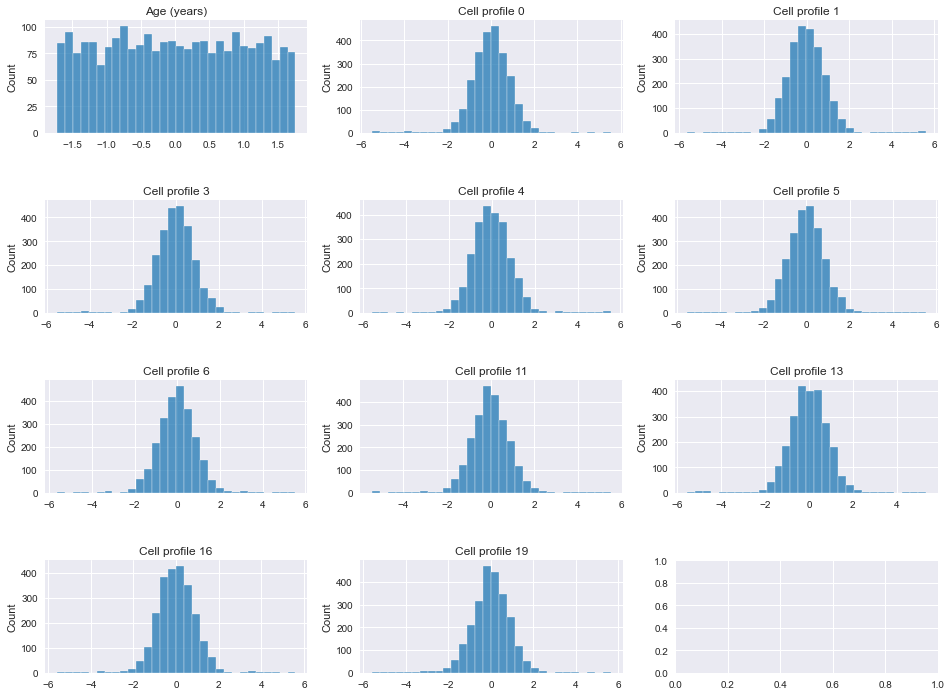

In [27]:
num_feature_dist_plot(df=X_clean_df, n_col=3, fig_width=16, fig_height=12, hspace=0.6, wspace=0.2)

### Regularization
If time permits I plan to explore L1-regularization (LASSO) for feature selection. I'm curious how feature selected models might differ from the full model that I am about to fit. Theoretically, this would help limit the effects of multicollinearity and outliers. 

**NOTE:** Below are features selected from LASSO with an alpha level of 0.1. I'm not exactly sure how to use this information though, and want to be careful. I don't think that it's as easy as removing all of these features in my final linear regression model; this seems like an oversimplification. I'm also not sure how to include the categorical variables with LASSO. I attempted to include these, and then found that the white racial group was the only racial group selected.

In [28]:
# Feature selection using LASSO
sel_ = SelectFromModel(Lasso(alpha=0.1, random_state=10))
sel_.fit(X_clean_df.to_numpy(), y)
sel_.get_support()
X_clean_df.loc[:, sel_.get_support()]

,Age (years),Cell profile 3,Cell profile 4,Cell profile 11
0,0.606607,-1.525878,-1.200674,-0.010346
1,0.990734,4.486851,-0.619981,0.635648
2,0.732788,-1.210008,-1.089198,-0.818056
3,-0.908179,0.708043,-3.347861,-0.052019
4,0.833704,0.523945,0.234297,0.437823
...,...,...,...,...
2495,0.273011,-0.089807,0.084368,0.236253
2496,1.321863,-0.537661,0.729866,0.282951
2497,-1.553667,1.423700,-0.531564,0.290395
2498,-0.667919,-0.308655,0.052159,-0.154189


### Merge in Categorical Features

In [29]:
X_clean_df[binary_X] = X_ohe[binary_X]
X_clean_df.head(5)

,Age (years),Cell profile 0,Cell profile 1,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 11,Cell profile 13,Cell profile 16,Cell profile 19,Sex,American Indian or Alaska Native,Asian,Black or African American,Hispanic or Latino,Native Hawaiian or other Pacific Islander,White
0,0.606607,-0.158217,-1.017288,-1.525878,-1.200674,-0.177085,0.109791,-0.010346,3.520220,1.644792,-1.400281,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.990734,0.465488,-0.638853,4.486851,-0.619981,-0.926268,0.639015,0.635648,-0.843517,0.950682,0.696580,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.732788,0.454761,-0.851144,-1.210008,-1.089198,-0.068787,0.360261,-0.818056,-0.135263,0.447314,0.518818,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.908179,0.322712,0.013303,0.708043,-3.347861,-0.408577,0.854675,-0.052019,-0.765562,-0.697318,-0.652432,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.833704,0.715238,0.134538,0.523945,0.234297,-0.150843,0.197583,0.437823,-1.198944,0.161794,-0.772072,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Simple Linear Regression

In [30]:
# Split df into target/features
target = 'Survival time (years)'
X = X_clean_df.to_numpy()            # Get this from clean set
y = data.loc[:, target].to_numpy()   # Get this from original set

## Fit Model

In [31]:
# State variables in terms of x1, x2, x3... - want to pull directly from data set
model_varnames = [f'x{i+1}' for i in range(0, len(X_clean_df.columns))]
varnames = X_clean_df.loc[:, X_clean_df.columns != target].columns
varname_dict = dict(zip(model_varnames, varnames))
for key, value in varname_dict.items():
    print(f'{key}: {value}')

x1: Age (years)
x2: Cell profile 0
x3: Cell profile 1
x4: Cell profile 3
x5: Cell profile 4
x6: Cell profile 5
x7: Cell profile 6
x8: Cell profile 11
x9: Cell profile 13
x10: Cell profile 16
x11: Cell profile 19
x12: Sex
x13: American Indian or Alaska Native
x14: Asian
x15: Black or African American
x16: Hispanic or Latino
x17: Native Hawaiian or other Pacific Islander
x18: White


In [32]:
# Fit model and display results
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     321.9
Date:                Wed, 28 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:47:27   Log-Likelihood:                -5003.8
No. Observations:                2500   AIC:                         1.004e+04
Df Residuals:                    2482   BIC:                         1.015e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0084      0.056    162.247      0.0

## Residuals & Performance Metrics

In [33]:
# Set up output data frame to contain clean data, y, predictions and residuals
out_data = X_clean_df
out_data['y'] = data.loc[:, target]

# Use full set to get predictions and residuals
predictions = model.predict(X)
out_data['y_pred'] = predictions
out_data['residual'] = model.resid

# Performance metrics
print(f'MAE: {round(mean_absolute_error(y, predictions), 2)}')
print(f'MSE: {round(mean_squared_error(y, predictions), 2)}')
print(f'R-squared: {round(r2_score(y, predictions), 2)}')
print(f'Adjusted R-squared: {round(model.rsquared_adj, 2)}')


MAE: 1.15
MSE: 3.21
R-squared: 0.69
Adjusted R-squared: 0.69


## Model Diagnostics

### Residuals vs Predicted Outcome

The residuals appear to be normally distributed, but there is a clear linear pattern shown here. We'll check the residuals as a function of age, but it is optimization is definitely needed.

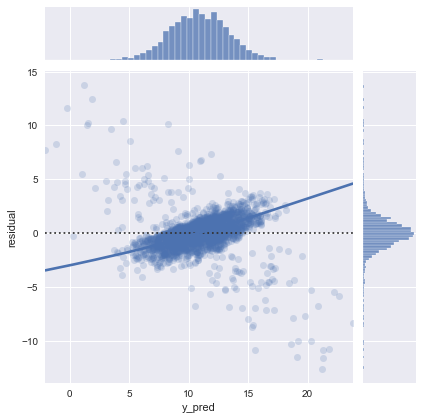

In [34]:
g = sns.JointGrid(data=out_data, x='y_pred', y='residual')
g.plot_joint(sns.residplot, lowess=True, scatter_kws={'alpha': 0.2})
g.plot_marginals(sns.histplot)
plt.show()

### Residuals vs Age

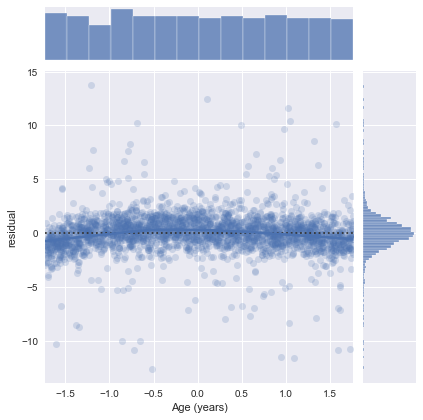

In [54]:
g = sns.JointGrid(data=out_data, x='Age (years)', y='residual')
g.plot_joint(sns.residplot, lowess=True, scatter_kws={'alpha': 0.2})
g.plot_marginals(sns.histplot)
plt.show()

In [ ]:
def num_feature_dist_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=30)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()